# 데이터와 정보 로드

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names


- 처음에 꽃의 클래스와 개수를 어디서 가져올까 고민을 헀다.
- 그러다 주어진 텐서플로우 링크를 찾아보고 메타데이터 안에 클래스 수, 이름과 같은 정보를 활용하여 코드를 작성하였다.
- num_classes:데이터셋에 포함된 클래스의 수를 나타냅니다. 예를 들어, 꽃 종류가 5개라면 num_classes는 5
- class_names: 데이터셋의 각 클래스에 해당하는 이름들의 리스트입니다. 예를 들어, ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']와 같은 이름들이 들어있을 수 있습니다.
- 바로 확인 할 수 없을 경우를 생각해서 아래와 같은 코드를 통해 확인 가능하다.

In [7]:
# 메타데이터 탐색
print("메타데이터 구조:")
print(metadata)

print("\n클래스 정보:")
print(metadata.features['label'])

print("\n클래스 수:")
print(metadata.features['label'].num_classes)

print("\n클래스 이름:")
print(metadata.features['label'].names)

# 추가적인 메타데이터 정보 확인
print("\n데이터셋 설명:")
print(metadata.description)

print("\n데이터셋 인용:")
print(metadata.citation)

메타데이터 구조:
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/aiffel/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

클래스 정보:
ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

클래스 수:
5

클래스 이름:
['dandelion', 'daisy', 'tulips', 'su

# 데이터셋 준비 및 전처리

In [8]:

IMG_SIZE = 224  # VGG16의 기본 입력 크기에 맞게 설정

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # 픽셀값 정규화
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train = raw_train.map(format_example).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation = raw_validation.map(format_example).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test = raw_test.map(format_example).batch(BATCH_SIZE)

# 모델 설계(VGG16)

In [9]:
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                         include_top=False,
                                         weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


# 모델 학습

In [10]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

EPOCHS = 10
history = model.fit(train,
                    epochs=EPOCHS,
                    validation_data=validation)


Epoch 1/10
81/81 [==============================] - 15s 161ms/step - loss: 2.0203 - accuracy: 0.2701 - val_loss: 1.4146 - val_accuracy: 0.5218
Epoch 2/10
81/81 [==============================] - 14s 167ms/step - loss: 1.5616 - accuracy: 0.4204 - val_loss: 1.1791 - val_accuracy: 0.6635
Epoch 3/10
81/81 [==============================] - 14s 170ms/step - loss: 1.3173 - accuracy: 0.5068 - val_loss: 0.9704 - val_accuracy: 0.7234
Epoch 4/10
81/81 [==============================] - 14s 163ms/step - loss: 1.1775 - accuracy: 0.5594 - val_loss: 0.8251 - val_accuracy: 0.7480
Epoch 5/10
81/81 [==============================] - 13s 159ms/step - loss: 1.0813 - accuracy: 0.5917 - val_loss: 0.7297 - val_accuracy: 0.7561
Epoch 6/10
81/81 [==============================] - 13s 158ms/step - loss: 0.9511 - accuracy: 0.6555 - val_loss: 0.6637 - val_accuracy: 0.7711
Epoch 7/10
81/81 [==============================] - 13s 159ms/step - loss: 0.9161 - accuracy: 0.6598 - val_loss: 0.6174 - val_accuracy: 0.7820

# 모델 성능 평가

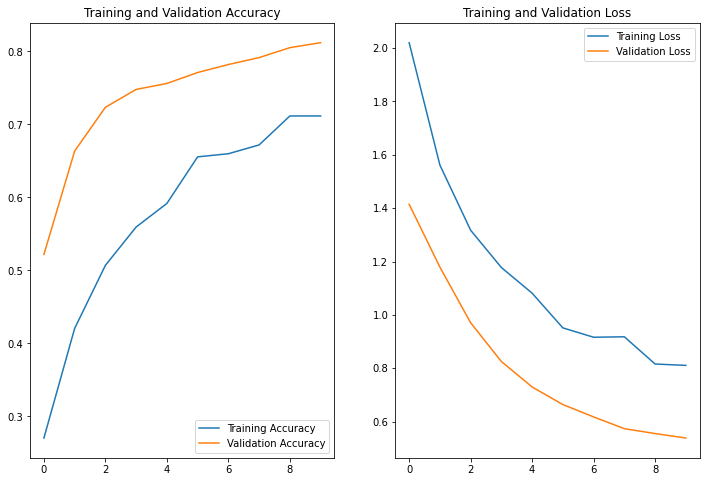

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [12]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test accuracy: {test_accuracy:.2f}")

12/12 [==============================] - 5s 421ms/step - loss: 0.5104 - accuracy: 0.8202
Test accuracy: 0.82


- 모델이 잘 학습은 되었으나, 모델의 성능이 0.82으로 기준치에 미치지 못하였다.
- 정확도는 오르고 LOSS는 줄어드는 형태로 학습은 잘 된 것 같다. 
- 성능을 향상 시킬 수 있는 다른 모델을 추가하여 학습을 진행하겠다. 

# 모델 설계 (Inception V3)

In [13]:
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 학습

In [14]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train,
                    epochs=EPOCHS,
                    validation_data=validation,
                    callbacks=[early_stopping])

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:249]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history_fine = model.fit(train,
                         epochs=10,
                         validation_data=validation,
                         callbacks=[early_stopping])


Epoch 1/30
81/81 [==============================] - 16s 127ms/step - loss: 0.9067 - accuracy: 0.7170 - val_loss: 1.0518 - val_accuracy: 0.7016
Epoch 2/30
81/81 [==============================] - 8s 89ms/step - loss: 0.5210 - accuracy: 0.8272 - val_loss: 0.4429 - val_accuracy: 0.8542
Epoch 3/30
81/81 [==============================] - 8s 90ms/step - loss: 0.4457 - accuracy: 0.8525 - val_loss: 0.4021 - val_accuracy: 0.8638
Epoch 4/30
81/81 [==============================] - 8s 90ms/step - loss: 0.3719 - accuracy: 0.8638 - val_loss: 0.4189 - val_accuracy: 0.8678
Epoch 5/30
81/81 [==============================] - 8s 90ms/step - loss: 0.3049 - accuracy: 0.8906 - val_loss: 0.4678 - val_accuracy: 0.8665
Epoch 6/30
81/81 [==============================] - 8s 89ms/step - loss: 0.2966 - accuracy: 0.8968 - val_loss: 0.4166 - val_accuracy: 0.8638
Epoch 7/30
81/81 [==============================] - 8s 90ms/step - loss: 0.2381 - accuracy: 0.9148 - val_loss: 0.4463 - val_accuracy: 0.8747
Epoch 8/30


### 변경사항
- 기본 모델을 VGG16에서 InceptionV3로 변경(InceptionV3는 일반적으로 더 높은 성능)
- 학습률 스케줄링을 도입하여 학습 과정에서 학습률을 점진적으로 감소
- Early stopping을 추가하여 과적합을 방지하고 최적의 모델을 저장
- Fine-tuning 단계를 추가. 초기 훈련 후 base 모델의 상위 레이어를 미세 조정.
- 학습 에포크 수를 30으로 늘림.

# 모델 성능 평가

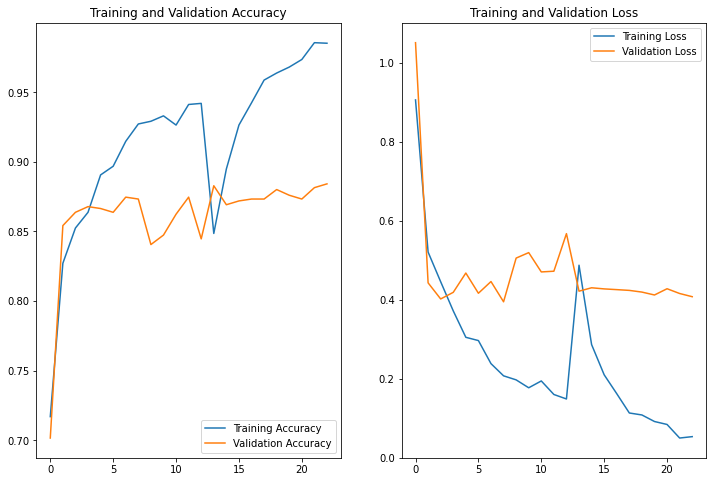

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test accuracy: {test_accuracy:.2f}")

12/12 [==============================] - 2s 150ms/step - loss: 0.3889 - accuracy: 0.8883
Test accuracy: 0.89


- 모델을 변경하고 test accuracy가 0.89가 나왔다. 여러번 돌렸는데 0.88~0.91 사이의 값으로 나온다.
- 그래프를 보면 accuracy가 올라가고 loss가 내려가고 있지만 Validation에서 일정 수준에서는 내려가지 않는 것을 알 수 있다.
- 이러한 LOSS를 줄여보기위해 Inception V3에 맞는 전처리도 따로 진행하였는데, 별다른 성능의 차이가 나지 않아서 생략했다.
- 그래도 VGG16모델 보다 성능이 좋아졌으며 LOSS 또한 0.6 -> 0.4로 줄어 모델 변경을 통한 학습이 효과적임을 알 수 있다. 

# 예측결과 확인

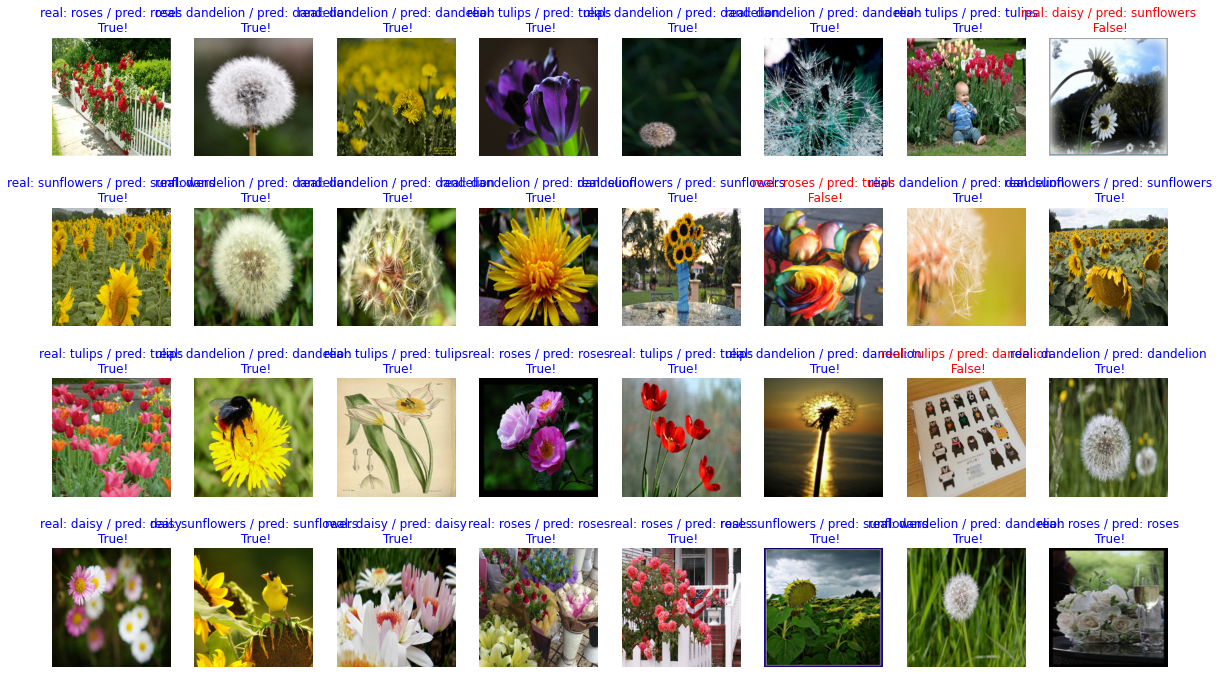

In [17]:
# 예측 결과 확인
for image_batch, label_batch in test.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(20, 12))
for idx, (image, label, prediction) in enumerate(zip(images[:32], labels[:32], predictions[:32])):
    plt.subplot(4, 8, idx+1)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize to [0,1] for display
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {class_names[label]} / pred: {class_names[prediction]}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

plt.show()

In [18]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) 

90.625


# 모델 활용

In [19]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np

def predict_image(image_url):
    # 이미지 다운로드
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((IMG_SIZE, IMG_SIZE))
    
    # 이미지를 numpy 배열로 변환
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence}%)")
    plt.axis('off')
    plt.show()

    print(f"이 이미지는 {predicted_class}일 확률이 {confidence}%입니다.")



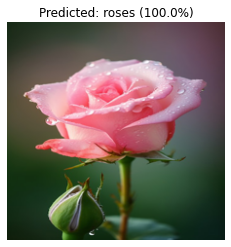

이 이미지는 roses일 확률이 100.0%입니다.


In [20]:
# 예시 이미지 URL (장미 이미지)
image_url = "https://img.freepik.com/free-photo/beautiful-rose-in-studio_23-2150737335.jpg?w=360&t=st=1723620534~exp=1723621134~hmac=5ce0f09c7b832def4f8a730fcca2514370289182524d7dd1334df60c00f62852"

# 이미지 예측
predict_image(image_url)

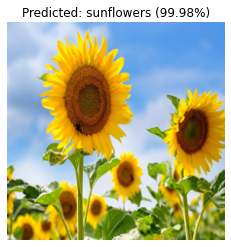

이 이미지는 sunflowers일 확률이 99.98%입니다.


In [21]:
# 예시 이미지 URL (해바라기 이미지)
image_url = "https://cdn.pixabay.com/photo/2019/07/10/18/06/sunflower-4329176_1280.jpg"

# 이미지 예측
predict_image(image_url)

- 실제로 데이터를 가지고 판별해보니 90퍼 정도로 잘 분별하는 것을 알 수 있다.
- 또한 외부의 꽃 사진을 가지고 와서 (장미, 해바라기)를 가지고 분류를 시키니까 분류를 잘 하는 것을 확인 할 수 있다.
